# Transformer Architecture


In this scenario, you will implement a simple decoder-only Transformer architecture and train the model using the language modeling objective.

# Architecture
This part of the notebook concerns the implementation of the Transformer architecture.
You can read more about transformers in the [original paper](https://arxiv.org/abs/1706.03762).

## Brief Description

### The Input

**Input to the transformer model is a sequence of tokens.   
The length of the input sequence is bounded by model context size.**


**Tokens** can correspond to individual characters, words, or short character sequences.  
Tokens are usually represented as natural numbers.  
The **tokenizer** is a program that converts text to a sequence of tokens.  
For example, consider the word `habitat` if we apply a GPT-3 tokenizer to it, then we will get a sequence of three tokens `[5976, 270, 265]` that corresponds to `["hab", "it", "at"]`.  
The common approach is to tokenize the text using between 30k to 50k different tokens.  
You can read more about tokenizers [here](https://huggingface.co/docs/transformers/tokenizer_summary).


### The Output
For each input token, the transformer model outputs a probability distribution on the next token given the previous tokens in the context.  
For example, if the model inputs three tokens `["hab", "it", "at"]` for the token `it` the model will output probability distribution $\mathbb{P}(t_3 | t_1= hab, t_2=it)$.  
In general if we denote the function induced by the transformer network as $T$ and tokens as $t_i$ for $i\in\{1\dots n\}$, then $T(t_i)=\mathbb{P}(t_i|t_{i-1}\dots t_1)$, where the probability $\mathbb{P}$ is the distribution that the training data was sampled from.




### Transformer Processing Pipeline - Overview
Let's look at the image below.  

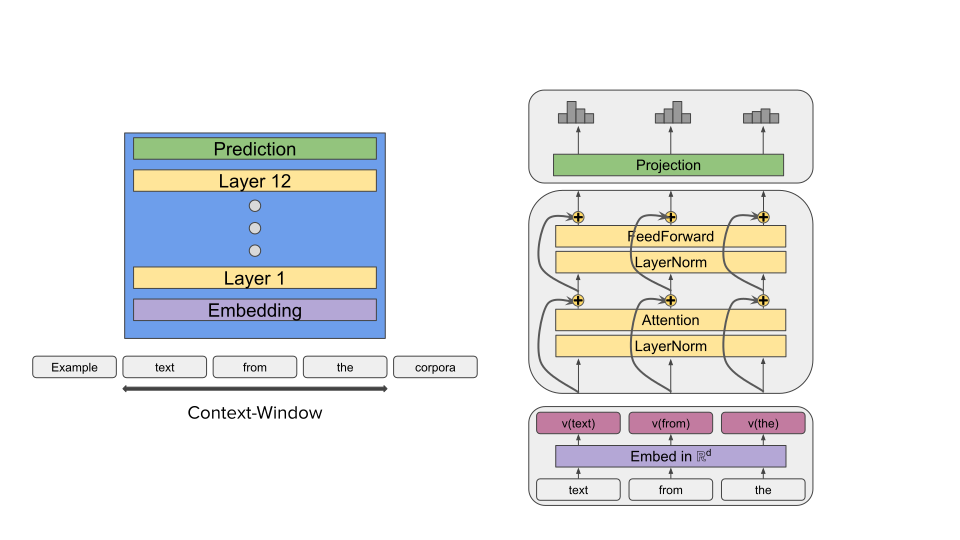



Processing in the Transformer model starts with converting each input token to a vector of real numbers using the Embedding layer.  
The Embedding layer stores a matrix of shape `(num_tokens, hidden_dim)` where each row contains an embedding vector corresponding to a particular token.  
Initially, these vectors are random, but as the model trains it learns to associate `appropriate meaning` with each token.


After the embedding, the tokens (now vectors) are passed through the Transformer layers.
In each layer, two major sublayers are used
* Attention
* FeedForward

Input to those two sublayers is normalized, and a skip connection is applied. This skip connection takes the input to the sublayer before normalization
and adds it to the result of the sublayer.  

Attention allows each token (now represented as a vector) to look at the preceding tokens.
FeedForward is usually implemented as a variant of MLP and allows the model to transform the hidden representation of each token.


After processing, we linearly project each token to a vector of length `num_tokens` and use softmax to generate probability distribution on the next token.

Note that each token (or the corresponding vector) is processed by each layer independently except for the Attention layer, where tokens can "look" at other tokens.

## FeedForward (1p)
Lets start with a simple task to implement the FeedForward layer.  
Follow the docstrings and fill the code below.  

In [1]:
import torch
from typing import List, Tuple, Any, Optional

HiddenT = torch.tensor  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]


class FeedForward(torch.nn.Module):
    """
    Inputs a tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]
    and processes it as follows:
    * project linearly from hidden_dim to inner_dim
    * apply activation function (GELU)
    * project linearly from inner_dim to hidden_dim
    """

    def __init__(self, hidden_dim: int, inner_dim: int) -> None:
        super().__init__()

        ### YOUR CODE STARTS ###
        self.linear1 = torch.nn.Linear(hidden_dim, inner_dim)
        self.activation = torch.nn.GELU()
        self.linear2 = torch.nn.Linear(inner_dim, hidden_dim)
        ###  YOUR CODE ENDS  ###

    def forward(self, x: HiddenT) -> HiddenT:
        # [BATCH, SEQ_LEN, HIDDEN_DIM]
        assert len(x.shape) == 3

        ### YOUR CODE STARTS ###
        x = self.linear1(x)
        x = self.activation(x)
        result = self.linear2(x)
        ###  YOUR CODE ENDS  ###

        # [BATCH, SEQ_LEN, HIDDEN_DIM]
        assert len(result.shape) == 3
        return result


##### TESTS START #####


def test_ff():
    def test_grad_and_shapes():
        feed_forward = FeedForward(16, 32)
        assert len(list(feed_forward.parameters())) >= 1
        x = torch.rand(3, 5, 16, requires_grad=True)
        y = feed_forward(x)
        assert x.shape == y.shape
        loss = y.sum()
        loss.backward()
        assert x.grad is not None

    test_grad_and_shapes()

test_ff()

#####  TESTS END  #####

## Attention
Let's implement the attention mechanism.
The attention mechanism will allow each token to aggregate information from preceding tokens using a weighted sum.  
Briefly speaking, attention can be described as follows.  
* Preparation:  
    * Use three linear projections (each parametrized by a different matrix) to create three vectors (query, key, value) from each token vector. Each of the vectors should have the length divisible by `num_heads`.
    * Split the created vectors into `num_heads` equal parts. That is we take each query/key/value vector and split it into `num_heads` equal vectors.
    * Apply positional encodings to queries and keys.
* The attention:
    * Calculate how well does each query match each key from the same head.  
    To be more precise, for each head independently calculate the inner product of each query vector with each key vector.   
    That is let Q be the matrix with query vectors as rows and K be the matrix with key vectors as rows.  
    The value needed from this step is $A$, given by $A=QK^T$.
    * Divide the value calculated above by square root of the per-head key dimension
    * Independently for each head convert the computed values into a probability distribution.  
    To be more precise, for the matrix $A$ above calculate row-wise softmax masking out for each query keys that it should not look at (keys that occur after the query in the sequence) - so the matrix $A$ should become lower triangular.
    * Independently for each head, calculate for each token a weighted sum of values.  
    To be more precise for $i$'th token we calculate $O[i] = \sum_{j} A[i, j] V[j]$. So for each input token, the resulting vector is a linear combination of values for other vectors, depending on how 'close' their keys were  to the query.
* The output
    * concatenate outputs of the heads and project them linearly to have the `hidden_dim` dimension


A few notes:
* masking out in softmax should be done so that the softmax values still sum up to ~$1$.
* do not use for loop to loop throughout attention heads

Follow the docstrings and fill in the code below.

### Attention - Create Q,K,V (1p)
Follow the docstrings and fill in the code below.

In [2]:
AttentionT = torch.tensor  # torch tensor of shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]


class AttentionCreateQKV(torch.nn.Module):
    """
    Given a tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]
    uses linear projections to create three tensors
    Query, Key and Value.
    Each of the created tensors has shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM].
    Where HEAD_DIM = HIDDEN_DIM // NUM_HEADS
    """

    def __init__(self, hidden_dim, num_heads) -> None:
        super().__init__()
        assert hidden_dim % num_heads == 0
        self.head_dim = hidden_dim // num_heads
        self.num_heads = num_heads

        ### YOUR CODE STARTS ###
        self.query_projection = torch.nn.Linear(hidden_dim, hidden_dim)
        self.key_projection = torch.nn.Linear(hidden_dim, hidden_dim)
        self.value_projection = torch.nn.Linear(hidden_dim, hidden_dim)
        ###  YOUR CODE ENDS  ###

    def forward(self, x: HiddenT) -> Tuple[AttentionT, AttentionT, AttentionT]:
        assert len(x.shape) == 3  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]

        ### YOUR CODE STARTS ###
        queries = self.query_projection(x).view(x.shape[0], x.shape[1], self.num_heads, self.head_dim)
        keys = self.key_projection(x).view(x.shape[0], x.shape[1], self.num_heads, self.head_dim)
        values = self.value_projection(x).view(x.shape[0], x.shape[1], self.num_heads, self.head_dim)
        result = (queries, keys, values)
        ###  YOUR CODE ENDS  ###

        assert len(result) == 3  # queries, keys, values
        for r in result:
            assert len(r.shape) == 4  # [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]
            assert r.shape[-2:] == (self.num_heads, self.head_dim)
            assert r.shape[:-2] == x.shape[:2]

        return result


##### TESTS START #####


def test_attn_create_qkv():
    def test_shapes():
        hidden_dim = 16
        num_heads = 8
        l = AttentionCreateQKV(hidden_dim=hidden_dim, num_heads=num_heads)
        x = torch.ones(3, 5, hidden_dim)
        ys = l(x)
        assert len(ys) == 3
        for y in ys:
            assert y.shape == x.shape[:-1] + (num_heads, hidden_dim // num_heads)

    test_shapes()


test_attn_create_qkv()

#####  TESTS END  #####

### Attention - Positional Encoding (2p)
A priori, transformer has little information about the relative positions of the tokens.
One of the more modern approaches to positional embeddings is Rotary Positional Embedding (RoPE), which you will implement.
You can read about RoPE [in the original paper](https://arxiv.org/abs/2104.09864) and also [here](https://nn.labml.ai/transformers/rope/index.html) in a more easily digestable form.  

Below is the outline of the idea:
+ let `v_0, ..., v_n` be a sequence of vectors of size `head_dim`, let's assume that `head_dim` is even.
+ for each vector group pack its entries into sets of size 2 (ex. `v_i = v_i.reshape(-1, 2)`)
+ generate a sequence of angles $o_1, ..., o_{\frac{hidden\_dim}{2}}$
+ process `v_i` as follows
    + treat `v_i` as a sequence of vectors of size `2`,
    + rotate `j`'th such vector by angle `i*o_j`

Follow the docstrings and fill in the code below.  
For simplicity you can recompute the angles with each forward pass.  

In [3]:
class RoPEPosEncoding(torch.nn.Module):
    """
    Given a tensor of shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]
    applies Rotary Positional Encoding.
    offset allows to apply rotary to sequnce part by part by telling how much tokens preecede the input in the sequence.
    """

    def __init__(self, head_dim, theta) -> None:
        super().__init__()

        assert head_dim % 2 == 0
        self.hidden_dim = head_dim

        ### YOUR CODE STARTS ###
        self.theta = 1. / (theta ** (torch.arange(0, self.hidden_dim, 2).float() / self.hidden_dim))
        ###  YOUR CODE ENDS  ###
    
    def forward(self, x: AttentionT, offset: int = 0):
        assert (
            len(x.shape) == 4
        )  # torch tensor of shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]
        assert offset >= 0

        ### YOUR CODE STARTS ###
        device = x.device
        seq_len = x.shape[1]
        
        seq_idx = torch.arange(seq_len).float()+ offset
        idx_theta = torch.einsum('n,d->nd', seq_idx, self.theta)
        idx_theta2 = torch.cat([idx_theta, idx_theta], dim=1)

        cos_cached = idx_theta2.cos()[None, :, None, :].to(device)
        sin_cached = idx_theta2.sin()[None, :, None, :].to(device)

        x_rope, x_pass = x[..., :self.hidden_dim], x[..., self.hidden_dim:]

        d_2 = self.hidden_dim // 2
        
        neg_half_x = torch.cat([-x[:, :, :, d_2:], x[:, :, :, :d_2]], dim=-1)
        x_rope = (x_rope * cos_cached[:seq_len]) + (neg_half_x * sin_cached[:seq_len])
        result = torch.cat([x_rope, x_pass], dim=-1)
        ###  YOUR CODE ENDS  ###

        assert result.shape == x.shape

        return result


##### TESTS START #####

def test_RoPE():
    def test_offset():
        rope = RoPEPosEncoding(16, 10000)
        x = torch.ones(1, 11, 3, 16)
        y = rope(x, offset=0)
        z = rope(x, offset=2)

        assert (torch.abs(z[:, :-2] - y[:, 2:])).sum() <= 1e-4
        assert (torch.abs(z[:, :2] - y[:, :2])).sum() >= 1e-4

    def test_initial_rotation():
        rope = RoPEPosEncoding(16, 10000)
        x = torch.ones(1, 11, 3, 16)
        y = rope(x, offset=0)

        assert (torch.abs(y[:, 0] - x[:, 0])).sum() <= 1e-4

    test_offset()
    test_initial_rotation()


test_RoPE()

#####  TESTS END  #####

### Attention (2p)
It is time to merge the things implemented above into an attention layer.

Follow the docstrings and fill in the code below.

For now you can just set the **cache** variable to **None**, as it isn't utilized in training.

Note that there are tests checking if the returned **cache** is of the correct shape, uncomment them if (hopefully after) you implement it in one of the subsequent exercises.

In [4]:
ACacheT = Tuple[
    torch.tensor, torch.tensor
]  # key, value, both of shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]


class Attention(torch.nn.Module):
    """
    Implements multi-head attention layer.
    Inputs tensor x of shape [BATCH, SEQ_LEN, hidden_dim].
    Uses head_proj to create three tensors q, k, v - each of shape
    [BATCH, SEQ_LEN, num_heads, head_dim].
    Then applies RoPE to q and k.
    Then calculates attention within each head, concatenates the results
    and linearly projects them to a tensor of shape [BATCH, SEQ_LEN, hidden_dim].

    Cache is a tuple of keys (kc) and values (vc) calculated in previous calls.
    For training the cache will be empty (tensors kc and vc should have shape [BATCH, 0, num_heads, hidden_dim]),
    For efficient generation, the cache will contain keys (kc), values (vc) of already read/generated tokens
    (this allows the generation of one additional token without recomputing the keys and values for all preceding tokens).
    After RoPE application to k, kc and vc are prepended to k and v respectively.

    The model outputs the linearly projected output of attention along with a cache extended with new keys and values.
    """
    def __init__(
        self, hidden_dim: int, num_heads: int, head_proj=AttentionCreateQKV
    ) -> None:
        super().__init__()

        assert hidden_dim % num_heads == 0

        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        ### YOUR CODE STARTS ###
        self.head_proj = head_proj(hidden_dim, num_heads)
        self.rope = RoPEPosEncoding(self.head_dim, 10000)
        self.out_proj = torch.nn.Linear(hidden_dim, hidden_dim)
        ###  YOUR CODE ENDS  ###

    def get_empty_cache(self, batch_size: int, device) -> ACacheT:
        return torch.empty(
            batch_size, 0, self.num_heads, self.head_dim, device=device
        ), torch.empty(batch_size, 0, self.num_heads, self.head_dim, device=device)

    def forward(self, x: HiddenT, cache: ACacheT) -> HiddenT: 
        assert len(x.shape) == 3  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]

        ### YOUR CODE STARTS ###
        queries, keys, values = self.head_proj(x)
        cache_size = cache[0].shape[1]
        
        queries = self.rope(queries, offset=cache_size)
        keys = self.rope(keys, offset=cache_size)
        
        cache_keys, cache_values = cache
        keys = torch.cat([cache_keys, keys], dim=1)
        values = torch.cat([cache_values, values], dim=1)
        cache = (keys, values)

        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        
        attn_scores = torch.matmul(queries, keys.transpose(-2, -1)) / (
                self.head_dim ** 0.5
        )
        
        # Masking out future positions
        mask = torch.triu(torch.ones_like(attn_scores), diagonal=cache_size+1)
        attn_scores -= 1e9 * mask

        attention_weights = torch.nn.functional.softmax(attn_scores, dim=-1)

        attention = torch.matmul(attention_weights, values)

        attention = attention.transpose(1, 2).reshape(x.shape[0], x.shape[1], self.hidden_dim)
        attention = self.out_proj(attention)
        
        ###  YOUR CODE ENDS  ###

        return attention, attention_weights, cache


##### TESTS START #####
def test_attention():
    def test_shapes():
        num_heads = 8
        hidden_dim = 16
        attn_layer = Attention(hidden_dim, num_heads)
        x = torch.ones(2, 5, hidden_dim)
        y, attn_w, _ = attn_layer(
            x, attn_layer.get_empty_cache(2, torch.device("cpu"))
        )
        assert y.shape == x.shape

        assert attn_w.shape == y.shape[:-2] + (num_heads, y.shape[-2], y.shape[-2])

    def test_shapes_cache():
        num_heads = 8
        hidden_dim = 16
        attn_layer = Attention(hidden_dim, num_heads)
        x = torch.ones(2, 5, hidden_dim)
        cache = torch.ones(2, 3, num_heads, hidden_dim // num_heads), torch.ones(
            2, 3, num_heads, hidden_dim // num_heads
        )
        y, attn_w, cache = attn_layer(x, cache)

        assert y.shape == x.shape
        assert len(cache) == 2
        assert cache[0].shape == y.shape[:-2] + (
            8,
            num_heads,
            hidden_dim // num_heads,
        )
        assert cache[0].shape == cache[1].shape
        assert attn_w.shape == y.shape[:-2] + (num_heads, y.shape[-2], y.shape[-2] + 3)

    def test_attention_masking():
        num_heads = 8
        hidden_dim = 16
        attn_layer = Attention(hidden_dim, num_heads)
        x = torch.ones(2, 5, hidden_dim)
        y, attn_w, cache = attn_layer(
            x, attn_layer.get_empty_cache(2, torch.device("cpu"))
        )

        assert (attn_w < 0).sum() <= 1e-4

        assert (torch.triu(torch.ones(5, 5), diagonal=1) * attn_w).sum() <= 1e-4

    test_shapes()

    # Uncomment after implementing cache
    test_shapes_cache()

    test_attention_masking()


test_attention()

#####  TESTS END  #####

## Implement the Layer Normalization (1p)

Implement the layer normalization, you can find the formula [here](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html). You should follow the formula that is used when the default parameters are passed.
You should not use the `LayerNorm` module, the goal is to implement the Layer Normalization from scratch.



In [5]:
class LayerNorm(torch.nn.Module):
    def __init__(self, hidden_dim, eps=1e-05) -> None:
        super().__init__()

        self.hidden_dim = hidden_dim
        self.eps = eps

        ### YOUR CODE STARTS ###
        self.gamma = torch.nn.Parameter(torch.ones(hidden_dim))
        self.beta = torch.nn.Parameter(torch.zeros(hidden_dim))
        ### YOUR CODE ENDS ###

    def forward(self, x: HiddenT) -> HiddenT:
        assert len(x.shape) == 3  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]

        ### YOUR CODE STARTS ###
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)+self.eps

        result = self.gamma * (x - mean) / (var ** 0.5) + self.beta
        ###  YOUR CODE ENDS  ###

        assert x.shape == result.shape
        return result


##### TESTS START #####
def test_layer_norm():


    @torch.no_grad
    def test_initial_norm():
        ln = LayerNorm(16)
        x = torch.rand((3, 5, 16))
        normalized = ln(x)
        assert torch.abs(torch.mean(normalized, dim=-1)).mean()  <= 1e-4
        assert torch.abs(torch.std(normalized, dim=-1, unbiased=False).mean() - 1) <= 1e-2


    def test_rising_norm():
        ln = LayerNorm(16)
        x = torch.rand((3, 5, 16))
        initial_norm = torch.sqrt((ln(x) ** 2).sum(dim=-1))

        optim = torch.optim.AdamW(ln.parameters(), lr=10)

        for i in range(100):
            optim.zero_grad()
            norm = torch.sqrt((ln(x) ** 2).sum(dim=-1))
            loss = -norm.mean()
            loss.backward()
            optim.step()

        final_norm = torch.sqrt((ln(x) ** 2).sum(dim=-1))
        assert final_norm.mean() - initial_norm.mean() > 100.0


    test_initial_norm()
    test_rising_norm()


test_layer_norm()

#####  TESTS END  #####

## Implement Transformer Block (1p)
You can use the picture at the beginning of this notebook for reference.  
Remeber to use Layer Normalization and skip connections.  

In [6]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, hidden_dim, ff_dim, num_heads) -> None:
        """
        ff_dim - internal dimension of feed_forward.
        num_heads - num attention heads
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        ### YOUR CODE STARTS ###
        self.norm1 = LayerNorm(hidden_dim)
        self.attention = Attention(hidden_dim, num_heads)
        self.norm2 = LayerNorm(hidden_dim)
        self.feed_forward = FeedForward(hidden_dim, ff_dim)
        ###  YOUR CODE ENDS  ###

    def get_empty_cache(self, batch_size: int, device):
        return self.attention.get_empty_cache(batch_size=batch_size, device=device)

    def forward(self, x: HiddenT, attn_cache: ACacheT) -> Tuple[HiddenT, ACacheT]:
        ### YOUR CODE STARTS ###
        x_norm = self.norm1(x)
        attn, _, cache = self.attention(x_norm, attn_cache)
        x = x + attn
        x_norm = self.norm2(x)
        ff = self.feed_forward(x_norm)
        result = x + ff
        ###  YOUR CODE ENDS  ###

        assert x.shape == result.shape

        return result, cache

## The Model Processing Pipeline
Model Processing Pipeline is already implemented below.

In [7]:
TokensT = torch.tensor # [BATCH, SEQ_LEN]
ModelLT = torch.tensor # [BATCH, SEQ_LEN, VOCAB_SIZE]
class Transformer(torch.nn.Module):
    def __init__(self, vocab_size: int, n_layers: int, hidden_dim: int, ff_dim: int, num_heads: int) -> None:
        super().__init__()

        self.vocab_size = vocab_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        self.embedding = torch.nn.Embedding(vocab_size, hidden_dim)

        self.layers = torch.nn.ModuleList([
            TransformerBlock(hidden_dim=hidden_dim, ff_dim=ff_dim, num_heads=num_heads) for _ in range(n_layers)
        ])

        self.final_proj = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: TokensT, cache : Optional[List[ACacheT]] = None) -> Tuple[ModelLT, List[ACacheT]]:
        assert len(x.shape) == 2 # [BATCH, SEQ_LEN]
        assert cache is None or len(cache) == self.n_layers

        if cache is None:
            cache = [l.get_empty_cache(x.shape[0], x.device) for l in self.layers]

        x = self.embedding(x)

        new_cache = []

        for l, c in zip(self.layers, cache):
            x, c = l(x, attn_cache=c)
            new_cache.append(c)

        x = self.final_proj(x)
        return x, new_cache

def test_transformer():

    def test_run():
        transformer = Transformer(16, 4, 32, 64, 4)
        x = torch.tensor([[1, 2, 3]])
        transformer(x)

    def test_device():
        transformer = Transformer(16, 4, 32, 64, 4)
        x = torch.tensor([[1, 2, 3]]).to(torch.device("cpu"))
        transformer.to(torch.device("cpu"))
        transformer(x)

    test_run()
    test_device()

test_transformer()

# Data Preparation
The code below prepares the data for model training.
You do not need to implement anything here.

The data is synthetically generated. For $n \geq INITIAL$, $a_n$ is a sample from the random variable $X_n$:

$$
  \begin{cases}
    \mathbb{P}(X_n = a_{n-1} + 1) = NEXT\_PROB \\
    \mathbb{P}(X_n = \sum_{i=1}^{INITIAL} a_{n-i}c_{n-i}) = 1 - NEXT\_PROB
  \end{cases}
$$

taken **mod** $VOCAB\_SIZE$.

In other words, $a_n$ is either $a_{n-1} + 1$ mod $VOCAB\_SIZE$ - with probability $NEXT\_PROB$ or given by a recurrence equation of the order $INITIAL$.

In python the step of calculating $a_n$ can implemented as follows, where we denote $a_n$ by $new$:
```
def __next__(self):
    if np.random.random() < self.next_prob:
      new = self.current[-1] + 1
    else:
      new = (self.current @ self.coeffs)

    new %= self.size
    self.current = np.append(self.current, new)[1:]

    return new
```

The initial terms $a_0, ..., a_{INITIAL-1}$ are sampled from a uniform distribution with the support $\{0, 1, \dots, VOCAB\_SIZE\}$.

The coefficients $c_0, ..., c_{INITIAL-1}$ are sampled from the same distribution.

In [8]:
import numpy as np

def generate_recursive(n_first, vocab_size, next_prob):
    assert 0 < vocab_size
    initial = np.random.randint(0, vocab_size, n_first)
    coeffs = np.random.randint(0, vocab_size, n_first)

    return initial, coeffs, vocab_size, next_prob

class SeqGen:
    """
    For generating recurrent sequences with stochastically repeating terms.
    """
    def __init__(self, initial, coeffs, size, next_prob):
        assert len(coeffs) == len(initial)
        self.initial = initial
        self.coeffs = coeffs
        self.size = size
        self.next_prob = next_prob

        self.current = initial

    def __iter__(self):
        return self

    def __next__(self):
        if np.random.random() < self.next_prob:
          new = self.current[-1] + 1
        else:
          new = (self.current @ self.coeffs)

        new %= self.size
        self.current = np.append(self.current, new)[1:]

        return new

    def __key(self):
        return (tuple(self.initial), tuple(self.coeffs), self.size, self.next_prob)

    def __hash__(self):
        return hash(self.__key())

    def __eq__(self, other):
        if isinstance(other, SeqGen):
            return self.__key() == other.__key()


def generate_dataset(gen_factory, seq_len, num_entries, exclude = []):
    """
    For generating datasets with num_entries elements each
    of length seq_len.

      gen_factory is a procedure that returns
        instance of SeqGen when called.

      seq_len is the length of the sequence to generate.

      num_entries is the number of sequences to generate.

      exclude is the set of sequences that aren't to be used in training
    """
    entries = []
    generators = []
    for e in range(num_entries):
        while True:
          seq_gen = gen_factory()
          if seq_gen in exclude:
              continue

          seq = []
          for s in range(seq_len + 1):
              seq.append(next(seq_gen))

          break

        generators.append(seq_gen)
        entries.append(seq)
    data = torch.tensor(entries, dtype=torch.long)
    x = data[:, :seq_len]
    y = data[:, 1:]       # we predict next token
    return torch.utils.data.TensorDataset(x, y), set(generators)


In [9]:
def example_generator(gen):
    """
      A procedure that returns a representation of
      a single data entrance.
    """
    def example_gen():
        return SeqGen(*gen())
    return example_gen

In [10]:
BATCH_SIZE = 128
SEQ_LEN = 64


VOCAB_SIZE = 7
NEXT_PROB = .1
INITIAL = 2


DEVICE = torch.device("cpu") # can be also cpu
PERM_EXAMPLE_GENERATOR = example_generator(lambda: generate_recursive(INITIAL, VOCAB_SIZE, NEXT_PROB))


TEST_DATASET, generators = generate_dataset(
    gen_factory=PERM_EXAMPLE_GENERATOR, seq_len=SEQ_LEN, num_entries=1000)
TRAIN_DATASET, _ = generate_dataset(
    gen_factory=PERM_EXAMPLE_GENERATOR, seq_len=SEQ_LEN, num_entries=10000, exclude=generators)


TRAIN_LOADER = torch.utils.data.DataLoader(
    TRAIN_DATASET, batch_size=BATCH_SIZE)
TEST_LOADER = torch.utils.data.DataLoader(TEST_DATASET, batch_size=BATCH_SIZE)

# Training and Evaluation (1p)
Evaluation loop is already implemented.  
Finish the implementation of training loop (use cross_entropy loss).  

Your model should achieve test accuracy >= 0.65 in at most 8 epochs (In fact it should be easy to get accuracy >= 0.75).

In [11]:
from tqdm import tqdm
import functools


@torch.no_grad
def eval_acc(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    model.eval()
    sum_acc = 0
    num_examples = 0
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        model_out, _ = model(x)

        acc = (torch.argmax(model_out, dim=-1) == y).to(torch.float32).sum()
        sum_acc += acc
        num_examples += model_out.shape[0] * model_out.shape[1]

    return sum_acc / num_examples


def eval_fn(step, model, dataloader):
    acc = eval_acc(model, dataloader)
    print(f"{step}: Avg eval accuracy {acc}")


def train(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    dataloader: torch.utils.data.DataLoader,
    eval_fn,
):
    model.train()

    for epoch in range(8):
        if epoch == 0:
            eval_fn(epoch, model)

        for i, (x, y) in tqdm(enumerate(dataloader)):
            ### YOUR CODE STARTS ###
            optimizer.zero_grad()  # Zero gradients
            
            x, y = x.to(DEVICE), y.to(DEVICE)

            # Forward pass
            predictions, _ = model(x)

            # Compute the loss
            loss = torch.nn.functional.cross_entropy(predictions.view(-1, VOCAB_SIZE), y.view(-1))

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()
            ###  YOUR CODE ENDS  ###

        eval_fn(epoch, model)
        


model = Transformer(
    vocab_size=VOCAB_SIZE, n_layers=4, hidden_dim=64, ff_dim=128, num_heads=4
)
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
train(
    model=model,
    optimizer=optimizer,
    dataloader=TRAIN_LOADER,
    eval_fn=functools.partial(
        eval_fn,
        dataloader=TEST_LOADER,
    ),
)

0: Avg eval accuracy 0.13770312070846558


79it [00:20,  3.82it/s]


0: Avg eval accuracy 0.4634687602519989


79it [00:17,  4.40it/s]


1: Avg eval accuracy 0.633593738079071


79it [00:17,  4.43it/s]


2: Avg eval accuracy 0.7127344012260437


79it [00:18,  4.23it/s]


3: Avg eval accuracy 0.7551249861717224


79it [00:19,  3.97it/s]


4: Avg eval accuracy 0.7787187695503235


79it [00:20,  3.93it/s]


5: Avg eval accuracy 0.7953437566757202


79it [00:24,  3.20it/s]


6: Avg eval accuracy 0.806265652179718


79it [00:20,  3.78it/s]


7: Avg eval accuracy 0.8133906126022339


# Using the Model
Remaining tasks consider implementing utilities for generating text with the model.

## Implement generation with cache (1p)
Make your transformer model store the computed keys and values in cache.

Utilize this property to implement a function for efficient generation.

Report the difference in execution time for the both versions for the provided example.

In [12]:
@torch.no_grad
def token_choice_greedy(model_logits: ModelLT):
    assert len(model_logits.shape) == 3 # [BATCH, SEQ, VOCAB_SIZE]
    return torch.argmax(model_logits[:, [-1], :], dim=-1)

@torch.no_grad()
def generate_naive(model: torch.nn.Module, input: TokensT, gen_length: int, token_choice = token_choice_greedy) -> TokensT:
    """
    Given an input of shape [BATCH, SEQ_LEN] uses the model to generate
    an output of shape [BATCH, gen_length] so that the output is the model
    response to the input according to token_choice strategy.
    """
    assert len(input.shape) == 2 # BATCH, SEQ
    model.eval()
    input = input.to(DEVICE)
    output = []
    for _ in range(gen_length):
        model_output, _ = model(input)
        next_tokens = token_choice(model_output)
        output.append(next_tokens.cpu())
        input = torch.concat([input, next_tokens], dim=-1)

    return torch.concat(output, dim=-1)



@torch.no_grad()
def generate_with_cache(model: torch.nn.Module, input: TokensT, gen_length: int, token_choice = token_choice_greedy) -> TokensT:
    """
    Given an input of shape [BATCH, SEQ_LEN] uses the model to generate
    an output of shape [BATCH, gen_length] so that the output is the model
    response to the input according to token_choice strategy.
    Generation is efficent in a sense that keys and values are not recomputed
    and the input to the model is batched.
    """
    assert len(input.shape) == 2 # BATCH, SEQ
    model.eval()


    ### YOUR CODE STARTS ###
    input = input.to(DEVICE)
    output = []
    cache = None
    for _ in range(gen_length):
        model_output, cache = model(input, cache)
        next_tokens = token_choice(model_output)
        output.append(next_tokens.cpu())
        input = next_tokens
    
    output = torch.concat(output, dim=-1)
    ###  YOUR CODE ENDS  ###

    return output


@torch.no_grad()
def test_generation(model):

    def test_equivalence():
        batch = 3
        for i in range(1, 20):
            input = torch.randint(0, VOCAB_SIZE, (batch, SEQ_LEN - i))
            output_naive_gen = generate_naive(model, input, i)
            output_cache_gen = generate_with_cache(model, input, i)
            assert (output_naive_gen == output_cache_gen).to(torch.int32).sum() == batch * i
            
    test_equivalence()

test_generation(model)

15.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
15.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
30.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
23.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
46.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
23.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
66.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
25.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
77.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
23.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
79.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
27.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
91.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
29.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
104 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops

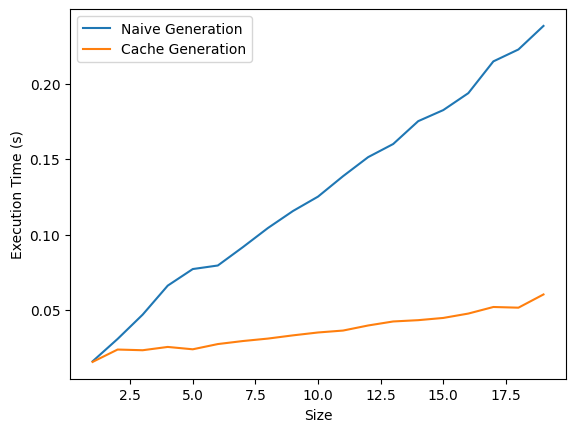

In [13]:
import timeit
import matplotlib.pyplot as plt

@torch.no_grad()
def test_generation_timing(model):
    def test_timing():
        batch = 3

        sizes = list(range(1, 20))
        naive_times = []
        cache_times = []
        
        for i in range(1, 20):
            input = torch.randint(0, VOCAB_SIZE, (batch, SEQ_LEN - i))

            output_naive_gen = generate_naive(model, input, i)
            output_cache_gen = generate_with_cache(model, input, i)

            assert (output_naive_gen == output_cache_gen).to(torch.int32).sum() == batch * i

            naive_time = %timeit -o -r 1 generate_naive(model, input, i)
            cache_time = %timeit -o -r 1 generate_with_cache(model, input, i)

            naive_times.append(naive_time.average)
            cache_times.append(cache_time.average)

        # Plot the results
        plt.plot(sizes, naive_times, label='Naive Generation')
        plt.plot(sizes, cache_times, label='Cache Generation')
        plt.xlabel('Size')
        plt.ylabel('Execution Time (s)')
        plt.legend()
        plt.show()

    test_timing()

test_generation_timing(model)

## Implement Nucleus Sampling and Temperature (2p)
Sometimes using the greedy approach is not the best solution (for example model may fixate on a specific topic or start to repeat itself).  
One of the methods to alleviate this is to use nucleus sampling along with appropriate softmax temperature.  
Complete the code following the docstrings.

Trivially, if the input sequence is constant for the first $INITIAL$ terms, the whole resulting sequence should be constant.

See what happens when the input sequence is constant of different sizes greater than $INITIAL$, $top\_p$ is increased between $0$ and $1$ and the temperature has values below one, equal to one and greater than one. Describe the observations and a plausible reasoning for why. Write the answer below the code.

In [14]:
@torch.no_grad
def get_dist_after_with_temp_and_topp(
    model_logits: ModelLT, top_p: float, t: float
) -> ModelLT:
    """
    Allows to alter softmax temperature and sample using most probable elements that constitute to roughly top_p
    probability mass of the distribution.

    Given the output of the model before softmax (model_logits of shape [BATCH, SEQ, VOCAB_SIZE]),
    computes the softmax with temperature t (softmax(model_logits / t, dim=-1))
    to get the probability distribution prob (of shape [BATCH, SEQ, VOCAB_SIZE]) on the next token.
    Then for each b, s orders elements of prob[b, s] in non-ascending order
    and selects a prefix (pref[b, s])) of them such that the cummulative probability of sampling an element from this
    prefix is < top_p but after adding the next element it is >= top_p.
    Then it adds the next element to pref[b, s] (now the cummulative probability is >= top_p),
    sets the probability of remaining elements to 0.0, and rescales the probability distribution.
    The implementation is vectorized.
    """

    assert len(model_logits.shape) == 3
    ### YOUR CODE STARTS ###
    probs = torch.nn.functional.softmax(model_logits / t, dim=-1)
    sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)
    cumsum_probs = torch.cumsum(sorted_probs, dim=-1)
    mask = cumsum_probs < top_p
    mask[:, :, 1:] = mask[:, :, :-1].clone()
    mask[:, :, 0] = 1
    mask = mask.float()
    
    result = torch.zeros_like(probs)
    result.scatter_(dim=-1, index=sorted_indices, src=sorted_probs * mask)
    result = result / result.sum(dim=-1, keepdim=True)
    ###  YOUR CODE ENDS  ###
    
    return result


@torch.no_grad
def token_choice_adv(model_logits: ModelLT, top_p: float, t: float) -> ModelLT:
    probs = get_dist_after_with_temp_and_topp(
        model_logits=model_logits[:, [-1], :], top_p=top_p, t=t
    )
    dist = torch.distributions.Categorical(probs=probs)
    return dist.sample()


##### TESTS START #####
@torch.no_grad
def test_nucleus():
    def test_dist_topp():
        # equal probs
        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 1.0, 1.0]]]), top_p=1.0, t=1.0
        )
        assert torch.abs(res - torch.tensor([1 / 3, 1 / 3, 1 / 3])).sum() <= 1e-4

        # non-equal probs

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[2.0, 3.0, 1.0]]]), top_p=0.0, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[2.0, 3.0, 1.0]]]), top_p=0.6, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=0.7, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0, 0.7311, 0.2689])).sum() <= 1e-2

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=1.0, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0900, 0.6652, 0.2447])).sum() <= 1e-2

    def test_temperature():
        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 1.0, 1.0]]]), top_p=1.0, t=3.0
        )
        assert torch.abs(res - torch.tensor([1 / 3, 1 / 3, 1 / 3])).sum() <= 1e-4

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=1.0, t=3.0
        )
        assert torch.abs(res - torch.tensor([0.2302, 0.4484, 0.3213])).sum() <= 1e-2

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=1.0, t=1 / 3
        )
        assert torch.abs(res - torch.tensor([0.0024, 0.9503, 0.0473])).sum() <= 1e-2

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=0.94, t=1 / 3
        )
        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

    def test_batching():
        res = get_dist_after_with_temp_and_topp(
            torch.tensor(
                [[[1.0, 3.0, 2.0], [1.0, 4.0, 8.0]], [[8.0, 4.0, 1.0], [3.0, 1.0, 2.0]]]
            ),
            top_p=0.7,
            t=1.0,
        )
        assert (
            torch.abs(
                res
                - torch.tensor(
                    [
                        [[0.0, 0.7311, 0.2689], [0.0, 0.0, 1.0]],
                        [[1.0, 0.0, 0.0], [0.7311, 0.0, 0.2689]],
                    ]
                )
            ).sum()
            <= 1e-2
        )

    test_dist_topp()
    test_temperature()
    test_batching()

@torch.no_grad
def test_token_choice_adv(model):
    def test_equivalence():
        batch = 3
        for i in range(1, 20):
            input = torch.randint(0, VOCAB_SIZE, (batch, SEQ_LEN - i))
            output_naive_gen = generate_naive(
                model, input, i, token_choice=token_choice_greedy
            )
            output_cache_gen = generate_naive(
                model, input, i, functools.partial(token_choice_adv, top_p=0.0, t=1.0)
            )
            assert (output_naive_gen == output_cache_gen).to(torch.int32).sum() == batch * i

    test_equivalence()


test_nucleus()
test_token_choice_adv(model)
#####  TESTS END  #####

You can check responses of your model using the code below

In [15]:
input_data = torch.ones((1, SEQ_LEN-10), dtype=int) * 2

generate_with_cache(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=0.1))

tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [19]:
SEQ_LEN_2 = 20

# Define the experiment function
def conduct_experiment(init_size, top_p_values, temperature_values):
    results = {}
    for top_p in top_p_values:
        for temp in temperature_values:
            # Generate input sequence with a constant prefix
            input_data = torch.ones((1, init_size), dtype=int) * 3

            # Generate sequence using the provided functions
            generated_sequence = generate_with_cache(
                model=model,
                input=input_data,
                gen_length=SEQ_LEN_2 - input_data.shape[-1],
                token_choice=functools.partial(token_choice_adv, top_p=top_p, t=temp)
            )
            # Check if the whole resulting sequence is constant
            is_constant = (generated_sequence == torch.ones_like(generated_sequence) * generated_sequence[0][0]).all()

            results[(init_size, top_p, temp)] = is_constant

    return results

# Set up parameters for the experiment
init_sizes = [SEQ_LEN_2-10, SEQ_LEN_2-3, SEQ_LEN_2-1]  # Different sizes for constant prefix
top_p_values = [0.1, 0.3, 0.5, 0.9]  # Vary top_p between 0 and 1
temperature_values = [0.1,0.5,  1.0, 2.0, 10.0]  # Vary temperature below 1, equal to 1, and above 1

# Run the experiment
experiment_results = {}
for init_size in init_sizes:
    experiment_results[init_size] = conduct_experiment(init_size, top_p_values, temperature_values)

# Analyze the results and provide observations and reasoning
for init_size, results in experiment_results.items():

    print(f"Observations for constant prefix of size {init_size}:")
    for (init_size,top_p, temp), is_constant in results.items():
        print(f"init_size: {init_size}, Top_p: {top_p}, Temperature: {temp}, Is Constant: {is_constant}")


Observations for constant prefix of size 10:
init_size: 10, Top_p: 0.1, Temperature: 0.1, Is Constant: True
init_size: 10, Top_p: 0.1, Temperature: 0.5, Is Constant: True
init_size: 10, Top_p: 0.1, Temperature: 1.0, Is Constant: True
init_size: 10, Top_p: 0.1, Temperature: 2.0, Is Constant: True
init_size: 10, Top_p: 0.1, Temperature: 10.0, Is Constant: True
init_size: 10, Top_p: 0.3, Temperature: 0.1, Is Constant: True
init_size: 10, Top_p: 0.3, Temperature: 0.5, Is Constant: True
init_size: 10, Top_p: 0.3, Temperature: 1.0, Is Constant: True
init_size: 10, Top_p: 0.3, Temperature: 2.0, Is Constant: True
init_size: 10, Top_p: 0.3, Temperature: 10.0, Is Constant: False
init_size: 10, Top_p: 0.5, Temperature: 0.1, Is Constant: True
init_size: 10, Top_p: 0.5, Temperature: 0.5, Is Constant: True
init_size: 10, Top_p: 0.5, Temperature: 1.0, Is Constant: False
init_size: 10, Top_p: 0.5, Temperature: 2.0, Is Constant: False
init_size: 10, Top_p: 0.5, Temperature: 10.0, Is Constant: False
ini

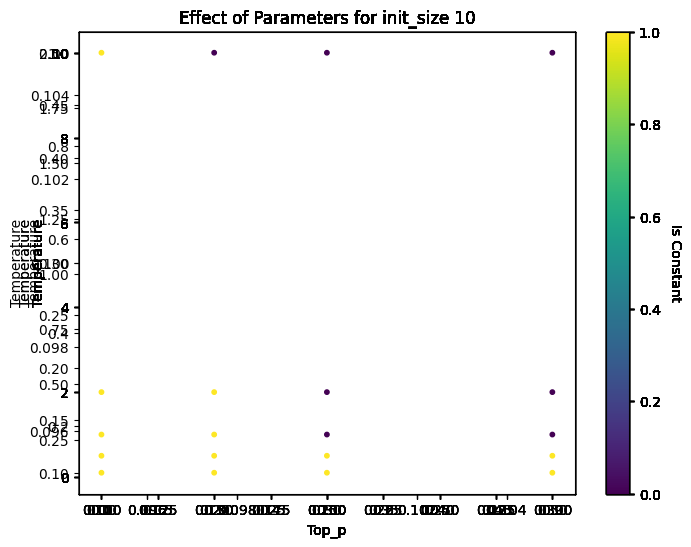

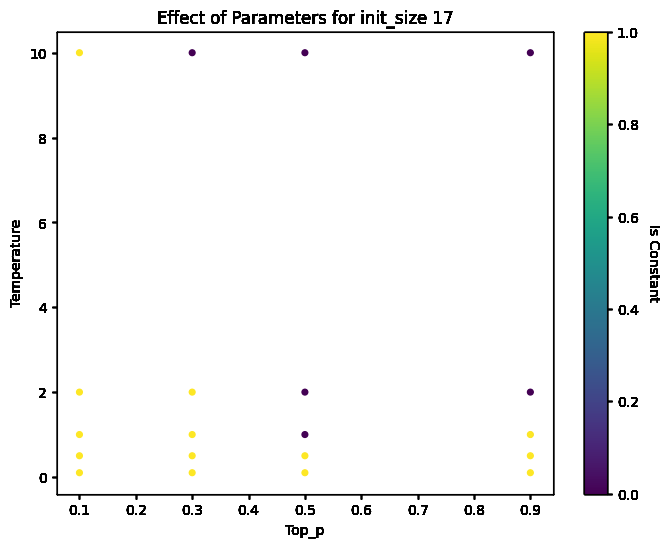

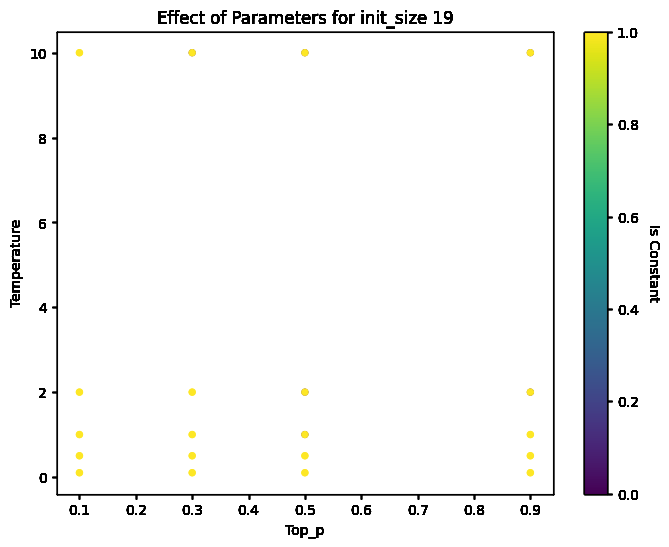

In [20]:
import matplotlib.pyplot as plt

# Extract data for visualization
init_sizes = []
top_p_values = []
temperature_values = []
is_constant_values = []

for init_size, results in experiment_results.items():
    fig = plt.figure(figsize=(8, 6))

    for (init_size_val, top_p, temp), is_constant in results.items():
        init_sizes.append(init_size_val)
        top_p_values.append(top_p)
        temperature_values.append(temp)
        is_constant_values.append(is_constant)

        # Scatter plot for visualization
        ax = fig.add_subplot(111)
        ax.scatter(top_p_values, temperature_values, init_sizes, c=is_constant_values, cmap='viridis', marker='o')

        # Set labels and title
        ax.set_xlabel('Top_p')
        ax.set_ylabel('Temperature')
        ax.set_title(f'Effect of Parameters for init_size {init_size}')

        # Add colorbar
        cbar = plt.colorbar(ax.scatter([], [], [], c=[], cmap='viridis'))
        cbar.set_label('Is Constant', rotation=270, labelpad=15)

    plt.show()


### Observations and Reasoning:

1. **Constant Prefix Size:**
   - For smaller constant prefix sizes , the resulting sequence may not be entirely constant, especially when higher values of `top_p` are used. This is because the model has more freedom to introduce variability in the generated sequence.

2. **Top_p Values:**
   - As `top_p` increases, the probability mass used for sampling becomes larger. Higher values of `top_p` may allow for more diverse samples, making it less likely for the entire sequence to be constant.

3. **Temperature Values:**
   - Lower temperature values (< 1) will make the model more deterministic, increasing the likelihood of the entire sequence being constant.
   - Temperature equal to 1 maintains a balance between exploration and exploitation.
   - Higher temperature values (> 1) introduce more randomness, making it less likely for the entire sequence to be constant.

4. **Interaction between Top_p and Temperature:**
   - The interaction between `top_p` and `temperature` is crucial. For higher values of `temperature`, the impact of `top_p` might be less pronounced, as the higher temperature introduces more randomness.



# Additional Evaluation
Following tasks consider additional evaluation of your model. Describe what you are able to observe on the plots and give a plausable reasoning why below the task.

## Per Token Accuracy (1p)
Calculate the per-token accuracy of you model. That is for each position $\{0, \dots, SEQ\_LEN\ - 1\}$ in the input calculate average accuracy across the test set for the prediction of the next token.  
Plot the results.

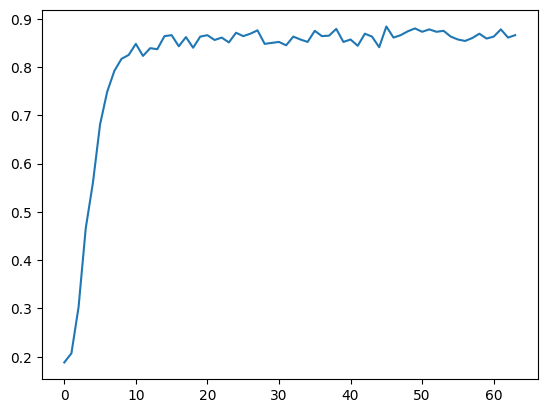

In [18]:
import matplotlib.pyplot as plt
@torch.no_grad
def calc_per_token_acc(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader):
    ### YOUR CODE STARTS ###
    per_token_acc = torch.zeros(SEQ_LEN)
    batch = 0
    for x, y in data_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        model_out, _ = model(x)
        predictions = torch.argmax(model_out, dim=-1)
        correct = (predictions == y).float()
        per_token_acc += correct.sum(dim=0).cpu()
        batch += x.shape[0]
    per_token_acc /= batch
    ###  YOUR CODE ENDS  ###
    return per_token_acc


per_token_acc = calc_per_token_acc(model, TEST_LOADER)
plt.plot(np.arange(per_token_acc.shape[0]), per_token_acc)
plt.show()

# Explanation:
The per-token accuracy increases with the number of tokens in the sequence. This is because the model has more information to make predictions for the next token. Later accuracy varies as some tokens are easier to predict than others. Overall the increasing accuracy suggests that the model is learning the underlying pattern in the data, and is able to make better predictions for the next token as it sees more tokens to base its predictions on.
